# Modules importeren

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import sklearn.metrics.pairwise as pw
import re
import spacy
import pandas as pd
import numpy as np
import sklearn
import os
from IPython.display import clear_output

def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

# Functies initialiseren

In [2]:
%%time
def split_data(data, d = 0.75):
    """Split data in a training and test set.
    
    Arguments:
    data -- any dataFrame.
    d    -- the fraction of data in the training set
    """
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

def pivot_ratings(df):
    """Creates a utility matrix for user ratings for movies
    
    Arguments:
    df -- a dataFrame containing at least the columns 'movieId' and 'genres'
    
    Output:
    a matrix containing a rating in each cell. np.nan means that the user did not rate the movie
    """
    return df.pivot_table(values='stars', columns='user_id', index='business_id')

def create_similarity_matrix_cosine(matrix):
    """Creates a adjusted(/soft) cosine similarity matrix.
    
    Arguments:
    matrix -- a utility matrix
    
    Notes:
    Missing values are set to 0. This is technically not a 100% correct, but is more convenient 
    for computation and does not have a big effect on the outcome.
    """
    mc_matrix = matrix - matrix.mean(axis = 0)
    return pd.DataFrame(pw.cosine_similarity(mc_matrix.fillna(0)), index = matrix.index, columns = matrix.index)


def mse(predicted_ratings):
    """Computes the mean square error between actual ratings and predicted ratings
    
    Arguments:
    predicted_ratings -- a dataFrame containing the columns rating and predicted rating
    """
    return ((predicted_ratings['stars'] - predicted_ratings['predicted rating'])**2).mean()
                            
# def extractCategories(businesses):
#     businessC = business.copy()[businesses['categories'].dropna()]
#     categories = [value for values in businesses['categories'].values for value in values]
#     return categories

def pivotCategories(df):
    """Create a one-hot encoded matrix for categories.
    
    Arguments:
    df -- a dataFrame containing at least the columns 'business_id' and 'categories'
    
    Output:
    a matrix containing '0' or '1' in each cell.
    1: the movie has the category
    0: the movie does not have the category
    """
    return df.pivot_table(index = 'business_id', columns = 'category', aggfunc = 'size', fill_value=0)


def recommended(predictions, threshold):
    return predictions[predictions['predicted rating'] >= threshold].reindex(columns=['user_id', 'movie_id'])  

def hidden(predictions, threshold):
    return predictions[predictions['predicted rating'] < threshold].reindex(columns=['user_id', 'movie_id'])

def used(predictions, threshold):
    return predictions[predictions['stars'] >= threshold].reindex(columns=['user_id', 'movie_id'])

def unused(predictions, threshold):
    return predictions[predictions['stars'] < threshold].reindex(columns=['user_id', 'movie_id'])

def confusion(recommended, hidden, used, unused):

    true_pos = len(recommended.reindex(set(recommended.index).intersection(set(used.index))))
    false_pos = len(recommended.reindex(set(recommended.index).intersection(set(unused.index))))
    true_neg = len(hidden.reindex(set(hidden.index).intersection(set(used.index))))
    false_neg = len(hidden.reindex(set(hidden.index).intersection(set(unused.index))))
    return pd.DataFrame(index=['recommended', 'hidden'], columns=['used','unused'], data=[[true_pos, false_pos],[true_neg, false_neg]])

def precision(confusion_matrix):
    return confusion_matrix.loc['recommended', 'used']/(confusion_matrix.loc['recommended','unused']+confusion_matrix.loc['recommended', 'used'])

def recall(confusion_matrix):
    return confusion_matrix.loc['recommended', 'used']/(confusion_matrix.loc['recommended', 'used']+confusion_matrix.loc['hidden', 'used'])

def get_pr(frame, threshold_recommended, threshold_used):
    # return precision and recall from DataFrame
    
    # get recommended, hidden, used, unused
    r = recommended(frame, threshold_recommended)
    h = hidden(frame, threshold_recommended)
    u = used(frame, threshold_used)
    un = unused(frame, threshold_used)
    
    confusion_matrix = confusion(r, h, u, un) 
    
    p = precision(confusion_matrix)
    r = recall(confusion_matrix)
    
    return p, r

def stripSplit(string):
    return [value.strip('& ').lower() for value in string.split(',')]

def extractCategories(business):
    """Create an unfolded genre dataframe. Unpacks genres seprated by a ',' into seperate rows.

    Arguments:
    movies -- a dataFrame containing at least the columns 'business_id' and 'categoires' 
              where genres are seprated by ','
    """
    genres_m = business.apply(lambda row: pd.Series([row['business_id']] + row['categories']), axis=1)
    stack_genres = genres_m.set_index(0).stack()
    df_stack_genres = stack_genres.to_frame()
    df_stack_genres['business_id'] = stack_genres.index.droplevel(1)
    df_stack_genres.columns = ['category', 'business_id']
    return df_stack_genres.reset_index()[['business_id', 'category']]

def extract_genres(movies):
    """Create an unfolded genre dataframe. Unpacks genres seprated by a '|' into seperate rows.

    Arguments:
    movies -- a dataFrame containing at least the columns 'movieId' and 'genres' 
              where genres are seprated by '|'
    """
    genres_m = movies.apply(lambda row: pd.Series([row['business_id']] + row['categories'].split(',')), axis=1)
    stack_genres = genres_m.set_index(0).stack()
    df_stack_genres = stack_genres.to_frame()
    df_stack_genres['business_id'] = stack_genres.index.droplevel(1)
    df_stack_genres.columns = ['category', 'business_id']
    return df_stack_genres.reset_index()[['business_id', 'category']]

def create_similarity_matrix_jaccard(matrix):
    m11 = matrix @ matrix.T
    m10 = pd.DataFrame(matrix.sum(axis = 1).values + np.zeros(m11.shape), index = m11.index, columns = m11.index)
    m01 = m10.T
    return m11/(m01 + m10 - m11)

def split_data(data, d = 0.75):
    """Split data in a training and test set.
    
    Arguments:
    data -- any dataFrame.
    d    -- the fraction of data in the training set
    """
    np.random.seed(seed=5)
    mask_test = np.random.rand(data.shape[0]) < d
    return data[mask_test], data[~mask_test]

def predict_ratings(similarity, utility, to_predict):
    """Predicts the predicted rating for the input test data.
    
    Arguments:
    similarity -- a dataFrame that describes the similarity between items
    utility    -- a dataFrame that contains a rating for each user (columns) and each movie (rows). 
                  If a user did not rate an item the value np.nan is assumed. 
    to_predict -- A dataFrame containing at least the columns movieId and userId for which to do the predictions
    """
    # copy input (don't overwrite)
    ratings_test_c = to_predict.copy()
    # apply prediction to each row
    ratings_test_c['predicted rating'] = to_predict.apply(lambda row: predict_ids(similarity, utility, row['user_id'], row['business_id']), axis=1)
    return ratings_test_c

def predict_ids(similarity, utility, userId, itemId):
    # select right series from matrices and compute
    if userId in utility.columns and itemId in similarity.index:
        return predict_vectors(utility.loc[:,userId], similarity[itemId])
    return 0

def predict_vectors(user_ratings, similarities):
    # select only movies actually rated by user
    relevant_ratings = user_ratings.dropna()
    
    # select corresponding similairties
    similarities_s = similarities[relevant_ratings.index]
    
    # select neighborhood
    similarities_s = similarities_s[similarities_s > 0.0]
    relevant_ratings = relevant_ratings[similarities_s.index]
    
    # if there's nothing left return a prediction of 0
    norm = similarities_s.sum()
    if(norm == 0):
        return 0
    
    # compute a weighted average (i.e. neighborhood is all) 
    return np.dot(relevant_ratings, similarities_s)/norm

def select_neighborhood(similarities, ratings, k):
    """ selects all items with similarity > 0  """
    return similarities[(similarities.notna() & ratings.notna()) & (similarities>0)][:k]

def weighted_mean(neighborhood, ratings):  
    if len(neighborhood) != 0:
        # multiply similarity of items in neighborhood with the respective rating, then divide the sum with the sum 
        # of the similarities
        numerator = (neighborhood * ratings.reindex(neighborhood.index)).sum()
        denominator = neighborhood.sum()
        return numerator/denominator
    return np.nan

def addMean(prediction, userId):
    if prediction == 0:
        return userMeans[userId]
    return prediction

def recommendBusinesses(user, predictions, businesses, users, n=5, threshold_recommended=3):
    # get n amount of random ids where rating > threshold_recommended
    recommendedIds = predictions[(predictions['user_id'] == user) & (predictions['predicted rating'] >= threshold_recommended)].sample(frac=1)
    recommendedIds = list(recommendedIds['business_id'].values)[:n]
    
    # 
    businessNames = list(businesses[businesses['business_id'].isin(recommendedIds)]['name'].values)
    username = list(users[users['user_id'] == user]['name'].values)[0]
    return businessNames, recommendedIds, username

def printRecommmended(recommendBusinesses):
    print(f'For {recommendBusinesses[2]} we recommend the following business(es):')
    for business in recommendBusinesses[0]:
        print(f'{business}')
        
def multiPredict(userThreshold, businessThreshold, reviewType, algorithmType, reviews):
    """
    Function that returns the mse of predictions based on users and businesses with more than a certain amount of reviews.
    
    Arguments:
    userThreshold     -- minimum amount of reviews a user needs to be included in the dataframe.
    businessThreshold -- minimum amount of reviews a business needs to be included in the dataframe.
    reviewType        -- wheteher the amount of reviews for a user is based on their total reviews in the region or not.
                         Takes either "local count" or "review_count" as values, respectively.
    predictionType    -- which algorithm to use. Takes either "user", "item", "content", "random" or "mean" as values.
    """
    
    # restrict reviews to users and businesses that exceed the threshold.
    userList = users[users[reviewType] >= userThreshold]['user_id'].values
    businessList = businessCopy[businessCopy['review_count'] >= businessThreshold]['business_id'].values
    reviewsCopy = reviews.copy()[(reviews['business_id'].isin(businessList)) & (reviews['user_id'].isin(userList))]
    
    # split data utility ratings
    trainingSet, testSet = split_data(reviewsCopy,.8)
    utilityRatings = pivot_ratings(trainingSet)
    
    # predict content based ratings
    if algorithmType == 'content':
        utilityGenres = pivotCategories(extractCategories(businessCopy))
        similarityGenres = create_similarity_matrix_jaccard(utilityGenres)
        predicted = predict_ratings(similarityGenres, utilityRatings, testSet)
        
    # predict item based ratings    
    elif algorithmType == 'item':
        similarityBusinesses = create_similarity_matrix_cosine(utilityRatings)
        predicted = predict_ratings(similarityBusinesses, utilityRatings, testSet)
        
    # predict user based ratings
    elif algorithmType == 'user':
        utilityRatings2 = utilityRatings.T.reindex(index=sorted(utilityRatings))
        similarityUsers = create_similarity_matrix_cosine(utilityRatings)
        predicted = predict_ratings(similarityUsers, utilityRatings2, testSet)
        
    # predict mean based ratings
    elif algorithmType == 'mean':
        predicted = testSet.copy()
        userMeans = pd.Series(users['average_stars'].values, users['user_id'], name='average_stars')
        predicted = predictedMean.merge(userMeans, on='user_id')
        predicted = predictedMean.rename(columns={"average_stars": "predicted rating"})
    
    # predict random based ratings
    else:
        predicted= testSet.copy()
        predicted['predicted rating'] = [0 + (5 * np.random.random_sample()) for x in range(len(predicted))]
        
    predicted = predicted[predicted['predicted rating'] != 0]    
    return predicted

def getYr(date):
    return int(date[:4])

Wall time: 0 ns


# Data inladen

In [3]:
%%time
# Load data for town called markham
data_path = './data/markham/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)

Wall time: 2.18 s


In [4]:
display(reviews.head())
display(businesses.head())
display(users.head())
display(tips.head())
display(checkins.head())

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,5,4,5,Tracy dessert had a big name in Hong Kong and ...,2016-05-07 01:21:02
1,9cW1B-T6M3ER3_rH_36h9Q,D-vYE3HILl7Qk1UhYqZXYQ,6sATfFam9_q9uod0I2aCsg,5.0,1,0,0,I really enjoyed my visit here.\nEverything wa...,2014-02-05 18:07:17
2,-W5OFbi3nixHZ0DTJmFK-w,h_2NGTYvjOc38cjx90rM5Q,b7e60tdyJxT_l-cstvMbfw,5.0,0,0,0,Just took the 6:30am class - My muscles have b...,2016-12-19 13:07:58
3,SWWVBFpSIsaWCgVePls5Yw,9lBu5VMrZpZEmp6scDYoaA,TtMRSbakzmWvfDDo5Ni3Hg,5.0,1,0,1,I remember going to this salon a few years ago...,2018-05-28 20:41:46
4,S7eyLPcXJLeD902kGeIHLA,-V-bzlNcuQc0otRfYKbZDg,6sATfFam9_q9uod0I2aCsg,1.0,0,0,0,I have taken my family to this place before. ...,2016-04-23 01:57:02


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,HBQG_DT8pfbkv8jiv3P6Gw,Winners,3105 Highway 7,Markham,ON,L3R 0T9,43.847997,-79.353733,2.5,8,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Shopping, Discount Store","{'Monday': '9:30-21:0', 'Tuesday': '9:30-21:0'..."
1,YOhtdvjmveAtsblep0CQrg,Moksha Yoga Markham,"5051 Highway 7, Suiite 2",Markham,ON,L3R 1N3,43.865262,-79.289421,4.0,23,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness & Instruction, Yoga, Education, Active...","{'Monday': '16:0-23:0', 'Tuesday': '16:30-23:0..."
2,_72dMXdWbVAgwB-Bxwz-mw,Champions Cuisine,"8321 Kennedy Road, unit 1071",Markham,ON,L3R,43.856381,-79.304410,3.5,7,0,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Chinese, Restaurants",None
3,1sVIau1rvgec3ul6g7EJag,Supermobile,E69 - 4300 Steeles Avenue E,Markham,ON,L3R 0Y5,43.825004,-79.305815,4.0,3,1,{'RestaurantsPriceRange2': '1'},"Mobile Phones, Shopping",None
4,tREKISC21iPORmC24fEpdw,Canada Robotix,"800 Denison Street, Unit 8",Markham,ON,L3R 5M9,43.825675,-79.335138,2.5,3,1,None,"Shopping, Electronics",None


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,z5y4ejvC8uaUg5fGEJHbRA,A,19,2013-05-28 17:49:42,33,4,3,,"5fvybUMH9N9Gx1zKw8UbBQ, I0HBD2I7uT_LU_gA9Gb9HA...",1,...,0,0,0,0,0,1,0,0,0,0
1,AsYMm_O4H-mwmWbmeACDHw,Christopher,318,2015-01-17 17:04:09,400,175,223,"2016,2017,2018","4I_AqfW1E_OLDskrgxxU0Q, 0hm1__RgRWYvHXxWfUJMyA...",24,...,4,1,0,0,2,4,4,4,2,5
2,B4GZ3kX1TpxJUCkpPqYqng,Vivian,20,2012-11-07 18:54:40,32,16,11,,"KBVL9aPlcLVwqyFQ__EeIA, jsEzCXrpP4jiHVLiAmCwdA...",2,...,0,0,0,0,1,3,2,2,3,0
3,FDw1j4PYezkEkddd1phDmg,Amy,78,2014-12-12 04:50:47,77,26,33,"2017,2018","AXh-myES40x4AmxlaEXGfg, 4_FbACsOh6BQEmICiJNIEQ...",10,...,1,0,0,0,1,3,2,2,0,0
4,foCj2hDfH84WGwglfAbDVA,Susie,124,2016-09-05 07:31:43,53,8,16,,"q8sQX_8uQvP0WDsAmeNdKg, Xj1ODF2MaMFkK_YUORjLVg...",3,...,0,0,0,0,0,0,2,2,0,0


,user_id,business_id,text,date,compliment_count
0,BqAMAM9wkjUyOJzqYOHg5g,bNqBMZ00lnhhfxzV8OhLfQ,Southern BBQ in Markham?! Whuuut?!,2013-06-01 20:30:47,0
1,Goa5tRkCURz-53WZAABBEw,hHYG2qoMId-y-HRkwNHoWQ,Quality seems to be going downhill,2013-05-19 23:24:10,0
2,s_SzQvkDfn18Cquma7DndQ,aa0uz1y1-ziTOveuE34HTw,10% discount happening during the soft opening,2017-03-14 03:42:36,0
3,yeX7tzZZWCnphQifRJglUg,MLYy937DjHHtE5Cwpg3NEQ,The neck of the fork is weak easily bends.,2013-07-06 14:55:05,0
4,Em4XpeXTKXVy4GjBL291pA,2_8_ipfxCRtpXesLdBCqig,CUTE DESSERTS AND LITTLE GIFTS! If you need a ...,2016-05-07 17:18:10,0


,business_id,date
0,-0DET7VdEQOJVJ_v6klEug,"2017-05-01 23:34:52, 2017-05-01 23:44:21, 2017..."
1,-0FA-Qdi3SPYIoJz9UQw-A,"2018-09-29 18:55:17, 2018-10-20 16:48:05, 2018..."
2,-0T0jfPnuBRdpNTXpOQZcA,"2012-12-28 14:40:47, 2013-02-25 16:04:45, 2013..."
3,-1LvG5O5lzfqUeti0Z3L5Q,2018-05-14 18:44:20
4,-2lSbNMhXKYu7URjEE59qA,"2012-02-04 02:13:43, 2012-06-21 16:57:41, 2012..."


# Analyse plots

([<matplotlib.axis.XTick at 0x234cb61fa48>,
 <a list of 11 Text xticklabel objects>)

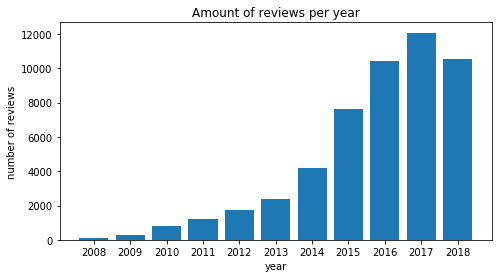

In [5]:
reviewsC = reviews.copy()
reviewsC['year'] = reviewsC['date'].map(getYr)

years = list(reviewsC.groupby('year').count().index)
amount = list(reviewsC.groupby('year')['review_id'].count().values)

plt.bar(years, amount)
plt.subplots_adjust(left=0, right=1)
plt.xlabel('year')
plt.ylabel('number of reviews')
plt.title('Amount of reviews per year')
plt.xticks(years)

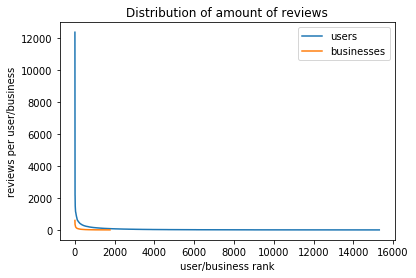

In [6]:
plt.plot(users["review_count"].sort_values(ascending=False).values)
plt.plot(businesses['review_count'].sort_values(ascending=False).values)
plt.xlabel('user/business rank')
plt.ylabel('reviews per user/business')
plt.title('Distribution of amount of reviews')
plt.legend(['users', 'businesses'], loc='upper right')

Text(0.5, 1.0, 'Histogram of review scores')

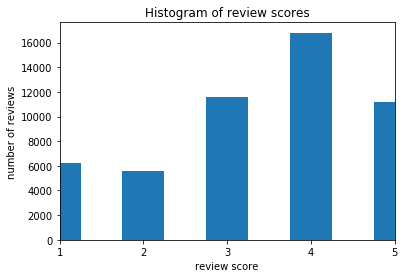

In [7]:
plt.hist(reviews['stars'].values, bins=np.arange(7)-0.5, rwidth=.5)
plt.xticks([1,2,3,4,5])
plt.xlim(1,5)
plt.xlabel('review score')
plt.ylabel('number of reviews')
plt.title('Histogram of review scores')

Text(0.5, 1.0, 'Distribution of amount of reviews')

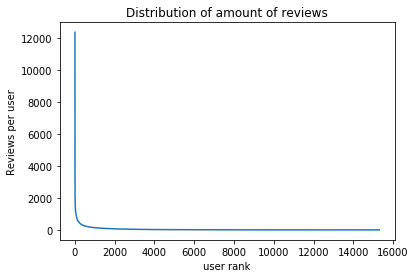

In [8]:
plt.plot(users["review_count"].sort_values(ascending=False).values)
plt.xlabel('user rank')
plt.ylabel('Reviews per user')
plt.title('Distribution of amount of reviews')

Text(0.5, 1.0, 'Distribution of amount of friends')

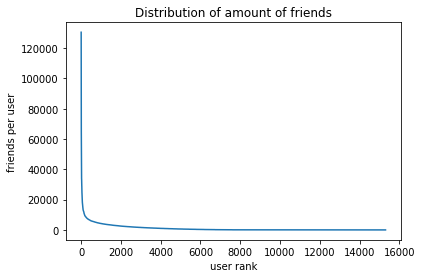

In [9]:
plt.plot(users['friends'].map(len).sort_values(ascending=False).values)
plt.xlabel('user rank')
plt.ylabel('friends per user')
plt.title('Distribution of amount of friends')

Text(0.5, 1.0, 'Distribution of amount of fans')

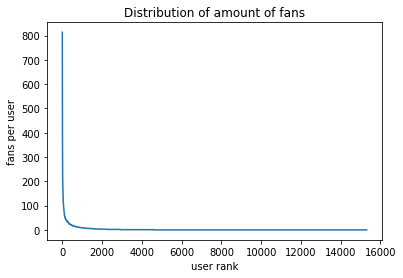

In [10]:
plt.plot(users["fans"].sort_values(ascending=False).values)
plt.xlabel('user rank')
plt.ylabel('fans per user')
plt.title('Distribution of amount of fans')

Text(0.5, 1.0, 'Distribution of useful votes')

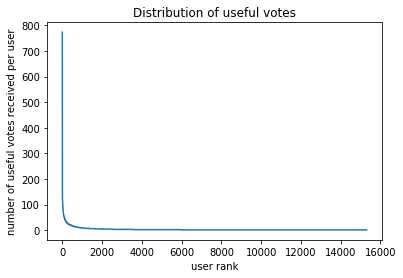

In [11]:
plt.plot(reviews.groupby('user_id')['useful'].count().sort_values(ascending=False).values)
plt.xlabel('user rank')
plt.ylabel('number of useful votes received per user')
plt.title('Distribution of useful votes')

Text(0.5, 1.0, 'Distribution of amount of reviews')

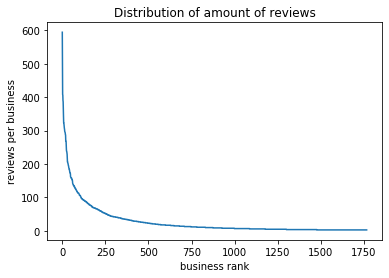

In [12]:
plt.plot(businesses['review_count'].sort_values(ascending=False).values)
plt.xlabel('business rank')
plt.ylabel('reviews per business')
plt.title('Distribution of amount of reviews')

In [13]:
businessC

NameError: name 'businessC' is not defined

In [ ]:
businessC = businesses.copy()

# get attributes
attributesList = [set(value.keys()) for value in businesses['attributes'].values if type(value) == dict]
attributes = {attribute for attributes in attributesList for attribute in attributes}

# create empty columns per attribute
for attribute in attributes:
    if attribute not in businessC:
        businessC[attribute] = pd.Series()

# set value to True if attribute is in 'attributes' of business
for attribute in attributes:
    for index in businessC.index:
        if businessC['attributes'][index] != None:
            if attribute in businessC['attributes'][index].keys():
                businessC[attribute][index] = True
            else:
                businessC[attribute][index] = False

# drop businesses with no attributes
businessC = businessC[businessC['attributes'].notna()]

# set amount of businesses with the attribute in 'attributes'
true =  [businessC[attribute].sum() for attribute in attributes]
false = [len(businessC[attribute])-value for value in true]

fig, ax = plt.subplots(figsize=(40, 8))
x = np.arange(len(attributes))

# Define bar width. We'll use this to offset the second bar.
bar_width = 0.4

# Note we add the `width` parameter now which sets the width of each bar.
b1 = ax.bar(x, true,
            width=bar_width)
# Same thing, but offset the x by the width of the bar.
b2 = ax.bar(x + .5, false,
            width=bar_width)

# fix tick interval
ax.set_xticks(x + bar_width / 2)

# fix tick labels
ax.set_xticklabels(attributes, rotation = 45, ha = 'right')
plt.rcParams.update({'axes.titlesize': 'xx-large',
                     'axes.labelsize': 'large',
                     'font.size': 20})


plt.legend(['True' ,'False'], loc='upper left')
plt.title('Amount of businesses that have a certain attribute')

In [ ]:
businessesC = businesses.copy()
businessesC = businessesC[businessesC['categories'].notna()]

# seperate values within categories
businessesC['categories'] = businessesC['categories'].map(stripSplit)

# determine categories and their occurences
categories = [value for values in businessesC['categories'].values for value in values]
occurences = Counter(categories)
categorySeries = pd.Series(list(occurences.values()), occurences.keys())

# drop bottom 1% and get x- and y-values
sortedSeries = categorySeries[categorySeries > 10].sort_values(ascending=False)
heights = sortedSeries.values
x = np.arange(len(sortedSeries.index))

# draw plot
fig, ax = plt.subplots(figsize=(40, 8))
b1 = ax.bar(x, heights)
ax.set_xticks(x)
ax.set_xticklabels(sortedSeries.index, rotation = 45, ha = 'right')
plt.title('Amount of businesses per category')

# Businesses en reviews bruikbaar maken

In [ ]:
# normalize business categories
businessCopy = businesses.copy()
businessCopy = businessCopy[businessCopy['categories'].notna()]
businessCopy['categories'] = businessCopy['categories'].map(stripSplit)
businessCopy.head()

In [ ]:
reviewsCopy = reviews.copy()[['user_id', 'business_id', 'stars']]
reviewsCopy.head()

# Algoritmes

In [ ]:
trainingSet, testSet = split_data(reviewsCopy, .8)
utilityRatings = pivot_ratings(trainingSet)
userMeans = pd.Series(users['average_stars'].values,users['user_id'], name='stars')

## Collaborative

### Item-based

In [ ]:
similarityBusinesses = create_similarity_matrix_cosine(utilityRatings)
predictedItem = predict_ratings(similarityBusinesses, utilityRatings, testSet)
zeroesItem = len(predictedItem[predictedItem['predicted rating'] == 0])
predictedItem = predictedItem[predictedItem['predicted rating'] != 0]
display(predictedItem.head())

### User-based

In [ ]:
utilityRatings2 = utilityRatings.T.reindex(index=sorted(utilityRatings))
similarityUsers = create_similarity_matrix_cosine(utilityRatings)
predictedUser = predict_ratings(similarityUsers, utilityRatings2, testSet)
zeroesUser = len(predictedUser[predictedUser['predicted rating'] == 0])
predictedUser = predictedUser[predictedUser['predicted rating'] != 0]
display(predictedUser.head())

## Content based

In [ ]:
%%time
utilityCategories = pivotCategories(extractCategories(businessCopy))
similarityCategories = create_similarity_matrix_jaccard(utilityCategories)
predictedContent = predict_ratings(similarityCategories, utilityRatings, testSet)
zeroesContent = len(predictedContent[predictedContent['predicted rating'] == 0])
predictedContent = predictedContent[predictedContent['predicted rating'] != 0]
display(predictedContent.head())

In [ ]:
print(zeroesItem)
print(zeroesUser)
print(zeroesContent)

## Random en mean

In [ ]:
predictedRandom = testSet.copy()
predictedRandom['predicted rating'] = [0 + (5 * np.random.random_sample()) for x in range(len(predictedRandom))]
display('random', predictedRandom.head())

predictedMean = testSet.copy()
userMeans =  pd.Series(users['average_stars'].values, users['user_id'], name='average_stars')
predictedMean = predictedMean.merge(userMeans, on='user_id')
predictedMean = predictedMean.rename(columns={"average_stars": "predicted rating"})
display('mean', predictedMean.head())

# MSE

In [ ]:
print(f'MSE for user-based: {mse(predictedUser):.2f}')
print(f'MSE for item-based: {mse(predictedItem):.2f}')
print(f'MSE for content based: {mse(predictedContent):.2f}')
print(f'MSE for random: {mse(predictedRandom):.2f}')
print(f'MSE for mean: {mse(predictedMean):.2f}')

# Recommendations

In [ ]:
# get users with the most recommended businesses
predictedUserT = predictedUser.copy()[predictedUser['predicted rating'] > 3].groupby('user_id').count().sort_values('stars', ascending=False)
predictedItemT = predictedItem.copy()[predictedItem['predicted rating'] > 3].groupby('user_id').count().sort_values('stars', ascending=False)
predictedContentT = predictedContent.copy()[predictedContent['predicted rating'] > 3].groupby('user_id').count().sort_values('stars', ascending=False)
predictedRandomT = predictedRandom.copy()[predictedRandom['predicted rating'] > 3].groupby('user_id').count().sort_values('stars', ascending=False)
predictedMeanT = predictedMean.copy()[predictedMean['predicted rating'] > 3].groupby('user_id').count().sort_values('stars', ascending=False)

In [ ]:
display(predictedUserT.head())
display(predictedItemT.head())
display(predictedContentT.head())
display(predictedRandomT.head())
display(predictedMeanT.head())

In [ ]:
recommendations = recommendBusinesses('CxDOIDnH8gp9KXzpBHJYXw', predictedContent, businesses, users)
printRecommmended(recommendations)
recommendations[1]

# Mean Dissimilarity

In [ ]:
def md(similarities, recommendations):
    similarityCopy = similarities.copy().reindex(columns=recommendations,index=recommendations)
    return (1 - similarityCopy.mean().mean())
    
ids = recommendations[1]
md(similarityCategories, ids)

# Evaluatie

## Plots

### Precision&Recall

In [ ]:
threshold_used = 3.9
threshold_recommended = list(np.arange(2.5,5.0,0.5))

# item based
precisions = [get_pr(predictedItem, threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(predictedItem, threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)
    
# # user based
# precisions = [get_pr(predictedUser, threshold_recommended[x], threshold_used)[0] 
#               for x in range(len(threshold_recommended))] 
# recalls = [get_pr(predictedUser, threshold_recommended[x], threshold_used)[1]
#               for x in range(len(threshold_recommended))] 

# plt.plot(recalls, precisions)
# for r, p, t in zip(recalls, precisions, threshold_recommended):
#     plt.text(r, p, t)
    
# random
precisions = [get_pr(predictedRandom, threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(predictedRandom, threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)
    
# mean
precisions = [get_pr(predictedMean, threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(predictedMean, threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)  

# content
precisions = [get_pr(predictedContent, threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(predictedContent, threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)    
    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision en recall plot')
plt.legend(['item based', 'random', 'mean', 'content'], loc = 'lower left')

### Dissimilarity

In [ ]:
itemIds = [predictedItem[predictedItem['predicted rating'] > threshold ]['business_id'].values for threshold in threshold_recommended]
itemMDs = [md(similarityCategories, Id) for Id in itemIds]

# userIds = [predictedUser[predictedUser['predicted rating'] > threshold ]['business_id'].values for threshold in threshold_recommended]
# userMDs = [md(similarityCategories, Id) for Id in userIds]

contentIds = [predictedContent[predictedContent['predicted rating'] > threshold ]['business_id'].values for threshold in threshold_recommended]
contentMDs = [md(similarityCategories, Id) for Id in contentIds]

randomIds = [predictedRandom[predictedRandom['predicted rating'] > threshold ]['business_id'].values for threshold in threshold_recommended]
randomMDs = [md(similarityCategories, Id) for Id in randomIds]

meanIds = [predictedMean[predictedMean['predicted rating'] > threshold ]['business_id'].values for threshold in threshold_recommended]
meanMDs = [md(similarityCategories, Id) for Id in meanIds]

In [ ]:
# item based
plt.plot(threshold_recommended, itemMDs)
# plt.plot(threshold_recommended, userMDs)
plt.plot(threshold_recommended, contentMDs)
plt.plot(threshold_recommended, randomMDs)
plt.plot(threshold_recommended, meanMDs)

    
plt.title('Mean Dissimilarity plot')
plt.xlabel('threshold_recommended')
plt.ylabel('Mean Dissimilarity')

plt.legend(['item based', 'content', 'random', 'mean'], loc = 'upper left')

### MSE's

In [ ]:
heights = sorted([mse(predictedItem), mse(predictedContent),  mse(predictedRandom),  mse(predictedMean)])
heights.append(np.nan)
bars = ['mean', 'item', 'content', 'random', 'user']
plt.bar(bars,heights)
plt.title('MSE plot')
plt.xlabel('Algorithm')
plt.ylabel('Mean Squared Error')

## Review dichtheid

In [ ]:
%%time
userThresholds = [8,10,50,100,200, 250, 300, 350, 400]

itemPredictions = [multiPredict(threshold, 'review_count', 'item', reviewsCopy) for threshold in userThresholds]
contentPredictions = [multiPredict(threshold, 'review_count', 'content', reviewsCopy) for threshold in userThresholds]
meanPredictions = [multiPredict(threshold, 'review_count', 'mean', reviewsCopy) for threshold in userThresholds]
randomPredictions = [multiPredict(threshold, 'review_count', 'random', reviewsCopy) for threshold in userThresholds]

In [ ]:
itemDensity = [mse(prediction) for prediction in itemPredictions]
contentDensity = [mse(prediction) for prediction in contentPredictions]
meanDensity = [mse(prediction) for prediction in meanPredictions]
randomDensity = [mse(prediction) for prediction in randomPredictions]

plt.plot(userThresholds, itemDensity)
plt.plot(userThresholds, contentDensity)
plt.plot(userThresholds, randomDensity)
plt.plot(userThresholds, meanDensity)

    
plt.title('MSE vs Density plot')
plt.xlabel('reviews per user')
plt.ylabel('MSE')

plt.legend(['item based', 'content', 'random', 'mean'], loc = 'center left')

In [ ]:
threshold_used = 3.9
threshold_recommended = list(np.arange(2.5,5.0,0.5))

# item based
precisions = [get_pr(itemPredictions[-1], threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(itemPredictions[-1], threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)
    
# # user based
# precisions = [get_pr(predictedUser, threshold_recommended[x], threshold_used)[0] 
#               for x in range(len(threshold_recommended))] 
# recalls = [get_pr(predictedUser, threshold_recommended[x], threshold_used)[1]
#               for x in range(len(threshold_recommended))] 

# plt.plot(recalls, precisions)
# for r, p, t in zip(recalls, precisions, threshold_recommended):
#     plt.text(r, p, t)
    
# random
precisions = [get_pr(randomPredictions[-1], threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(randomPredictions[-1], threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)
    
# mean
precisions = [get_pr(meanPredictions[-1], threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(meanPredictions[-1], threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)  

# content
precisions = [get_pr(contentPredictions[-1], threshold_recommended[x], threshold_used)[0] 
              for x in range(len(threshold_recommended))] 
recalls = [get_pr(contentPredictions[-1], threshold_recommended[x], threshold_used)[1]
              for x in range(len(threshold_recommended))] 
plt.plot(recalls, precisions)
for r, p, t in zip(recalls, precisions, threshold_recommended):
    plt.text(r, p, t)    
    
plt.xlim(0.0, 1.0)
plt.ylim(0.3, 1.0)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision en recall plot')
plt.legend(['item based', 'random', 'mean', 'content'], loc = 'lower left')

## Niet-plots

### Nullen verwijderd

In [ ]:
print(f'Amount of zeroes removed from predicted item: {zeroesItem}')
print(f'Amount of zeroes removed from predicted content: {zeroesContent}')
print(f'Amount of zeroesInv removed from predicted user: {zeroesUser}')

### Invloed van reviews per gebruiker/bedrijf op de MSE

In [ ]:
%%time
# create dataframe showing the effect of review count on the mse
indexRanges = [8,10,50,100,200]
columnRanges = indexRanges + [250, 300, 350, 400]
regularMSE = pd.DataFrame(index=indexRanges,columns=columnRanges)
for column in regularMSE.columns:
    regularMSE[column] = [mse(multiPredict(column, x, 'review_count', 'content', reviewsCopy)) for x in indexRanges]


In [ ]:
display(regularMSE)